In [1]:
import numpy as np

In [4]:
import torch

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [6]:
matplotlib_is_available = True

In [7]:
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

In [8]:
# Data params
data_mean = 4
data_stddev = 1.25
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
print("Using data [%s]" % (name))

Using data [Only 4 moments]


In [9]:
## DATA: Target data and generator input data
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

In [10]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

In [12]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
        
    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x  

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
        
    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

In [14]:
def extract(v):
    return v.data.storage().tolist()

In [20]:
def stats(d):
    return [np.mean(d), np.std(d)]

In [21]:
def get_moments(d):
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

In [22]:
def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)
    

In [23]:
def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()



/Users/liuchang/.conda/envs/conda_env/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0: D (0.6889556646347046 real_err, 0.6957948803901672 fake_err) G (0.6910749673843384 err); Real Dist ([3.9499535445272924, 1.205199473562865]),  Fake Dist ([-0.16907907477021217, 0.018331445228219563]) 
Epoch 100: D (0.6677896976470947 real_err, 0.6273491978645325 fake_err) G (0.7208607196807861 err); Real Dist ([3.971503085464239, 1.247045495815234]),  Fake Dist ([4.116176860809326, 0.023772825364301378]) 
Epoch 200: D (0.6986449956893921 real_err, 0.7073771357536316 fake_err) G (0.7184908390045166 err); Real Dist ([3.970497629880905, 1.2568593559856818]),  Fake Dist ([7.545034315109253, 1.1785055618602505]) 
Epoch 300: D (0.6075584292411804 real_err, 0.621327817440033 fake_err) G (0.7428746223449707 err); Real Dist ([4.069549364030361, 1.2850664796863391]),  Fake Dist ([2.4998107914924623, 0.033094891080281304]) 
Epoch 400: D (0.5656082034111023 real_err, 0.6463292241096497 fake_err) G (0.744191586971283 err); Real Dist ([3.93176224899292, 1.1676744680893782]),  Fake Dist ([8.

Epoch 4000: D (0.6933771967887878 real_err, 0.6933819055557251 fake_err) G (0.6931486129760742 err); Real Dist ([3.9910437933020293, 1.2722911980794158]),  Fake Dist ([4.068264288783073, 1.1722103620263922]) 
Epoch 4100: D (0.6930574178695679 real_err, 0.693240761756897 fake_err) G (0.6930882930755615 err); Real Dist ([4.040175447762013, 1.2881250487411156]),  Fake Dist ([4.1143973183631894, 1.1519401649283845]) 
Epoch 4200: D (0.6933280825614929 real_err, 0.692965030670166 fake_err) G (0.6941720843315125 err); Real Dist ([3.9774863047599793, 1.2965168878664872]),  Fake Dist ([4.0912395415306095, 1.161782345054457]) 
Epoch 4300: D (0.6931016445159912 real_err, 0.6930104494094849 fake_err) G (0.6932520866394043 err); Real Dist ([3.922441308438778, 1.2070770591637268]),  Fake Dist ([4.1222873734235765, 1.1749606950750573]) 
Epoch 4400: D (0.6937932968139648 real_err, 0.6925145983695984 fake_err) G (0.6926584243774414 err); Real Dist ([4.077477504462004, 1.2484844425206272]),  Fake Dist (

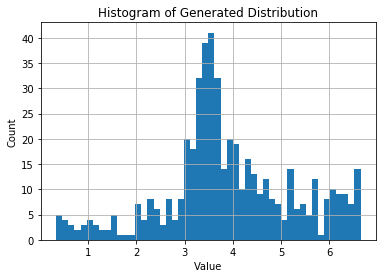

In [24]:
train()